**Carga datos búsquedas pseudocientificas**

In [ ]:
import pandas as pd
df1 = pd.read_csv("Evaluated final datasets/Evaluated_pseudo_1.csv")
df2 = pd.read_csv("Evaluated final datasets/Evaluated_pseudo_2.csv")

# Combinar los DataFrames
combined_df = pd.concat([df1, df2], ignore_index=True)

# Convertir la columna 'timestamp' a formato datetime
combined_df['timestamp'] = pd.to_datetime(combined_df['timestamp'])

# Obtener el nombre de la última columna
ultima_columna = combined_df.columns[-1]

# Renombrar la última columna
combined_df = combined_df.rename(columns={ultima_columna: 'Tematica del comentario'})
combined_df.dtypes

**Carga datos búsquedas científicas**

In [1]:
import pandas as pd
combined_df = pd.read_csv("Evaluated final datasets/Evaluated_scientific.csv")
combined_df = combined_df.iloc[:, 1:]
combined_df['timestamp'] = pd.to_datetime(combined_df['timestamp'])
combined_df.dtypes

comment                                 object
timestamp                  datetime64[ns, UTC]
is_response                               bool
response_of                             object
case_id                                 object
conversation_id                         object
language                                object
emotion                                 object
Tematica del comentario                 object
dtype: object

**Analisis del dataset escogido**

In [2]:
# Creación de la red
import networkx as nx
combined_df['next_tematica'] = combined_df['Tematica del comentario'].shift(-1)

G = nx.DiGraph()

for conversation_id, group_df in combined_df.groupby("conversation_id"):
    for index, row in group_df.iterrows():
        source = row['Tematica del comentario']
        target = row['next_tematica']
        
        # Evitar aristas con valores nulos
        if pd.notna(source) and pd.notna(target):  
            if G.has_edge(source, target):
                G[source][target]['weight'] += 1
            else:
                G.add_edge(source, target, weight=1)

In [ ]:
print("Número de nodos:", G.number_of_nodes())

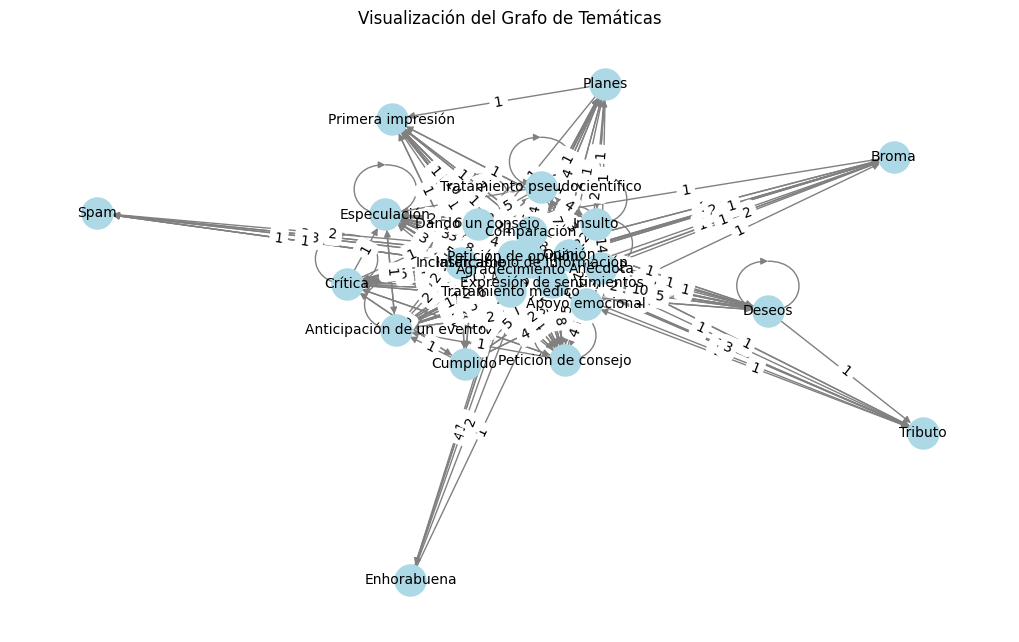

In [3]:
import matplotlib.pyplot as plt
import networkx as nx
# Dibujar el grafo
plt.figure(figsize=(10, 6))  # Ajusta el tamaño del gráfico
pos = nx.spring_layout(G, k=0.8,  seed=1)
#pos = nx.kamada_kawai_layout(G)
#pos = nx.circular_layout(G)

nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=500, font_size=10)
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): d["weight"] for u, v, d in G.edges(data=True)})

plt.title("Visualización del Grafo de Temáticas")
plt.show()

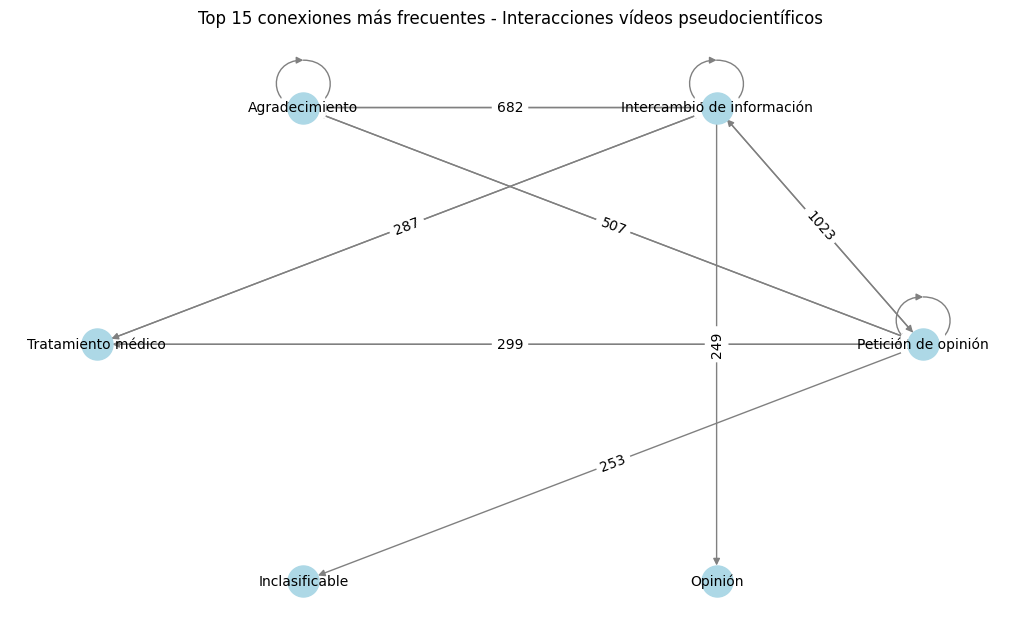

In [4]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

# Obtener las 10 aristas con mayor peso
top_edges = sorted(G.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:15]

# Crear un nuevo grafo solo con estas aristas
G_top = nx.DiGraph()
for source, target, data in top_edges:
    G_top.add_edge(source, target, weight=data['weight'])

# Dibujar el grafo filtrado
plt.figure(figsize=(10, 6))
#pos = nx.spring_layout(G_top, seed=5)  # Usamos un seed para que el layout sea reproducible
pos = nx.circular_layout(G_top)
#pos = nx.circular_layout(G)

nx.draw(G_top, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=500, font_size=10)
nx.draw_networkx_edge_labels(G_top, pos, edge_labels={(u, v): d["weight"] for u, v, d in G_top.edges(data=True)})

plt.title("Top 15 conexiones más frecuentes - Interacciones vídeos pseudocientíficos")
plt.show()

**Distribución del peso de las aristas**

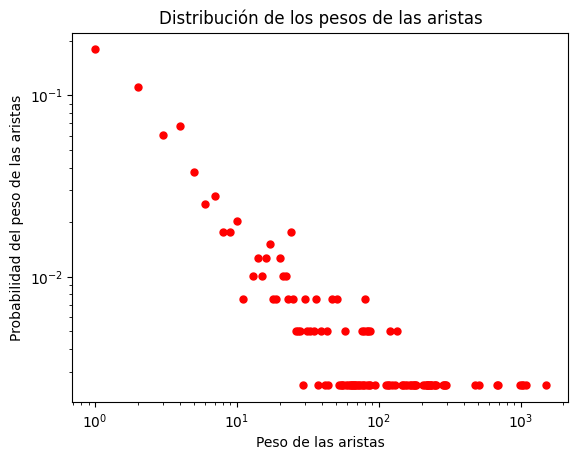

In [5]:
from collections import Counter
# Obtenemos los pesos de todas las aristas
edge_weights = [G[u][v]['weight'] for u, v in G.edges]

# Contamos la cantidad de veces que aparece cada peso, y el numero total de enlaces
weight_count = Counter(edge_weights)
total_links = len(G.edges) 

# Calculamos la probabilidad de cada peso.
weight_prob = {k: v / total_links for k, v in weight_count.items()}

# Extraemos los pesos y probabilidades
weights = list(weight_prob.keys())
probabilities = list(weight_prob.values())

# Mostramos graficamente la distribución de estas probabilidades
plt.figure()
plt.loglog(weights, probabilities, color='red', markersize=5, marker='o',linestyle='')
plt.xlabel("Peso de las aristas")
plt.ylabel("Probabilidad del peso de las aristas")
plt.title("Distribución de los pesos de las aristas")
plt.show()

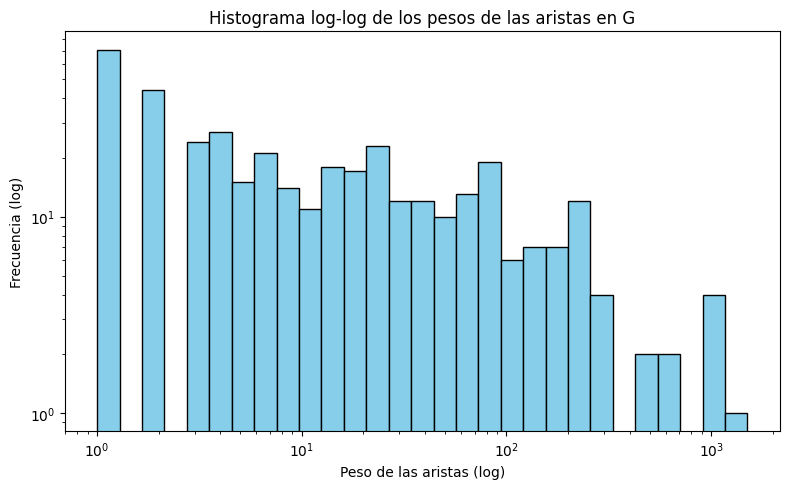

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Extraer los pesos de las aristas
weights = [data['weight'] for _, _, data in G.edges(data=True)]

# Filtrar pesos > 0 (por si acaso)
weights = [w for w in weights if w > 0]

# Crear bins logarítmicos
min_w = min(weights)
max_w = max(weights)
bins = np.logspace(np.log10(min_w), np.log10(max_w), num=30)

# Crear histograma
plt.figure(figsize=(8, 5))
plt.hist(weights, bins=bins, color='skyblue', edgecolor='black')

plt.xscale('log')  # Escala logarítmica en eje X
plt.yscale('log')  # Escala logarítmica en eje Y

plt.xlabel("Peso de las aristas (log)")
plt.ylabel("Frecuencia (log)")
plt.title("Histograma log-log de los pesos de las aristas en G")
plt.tight_layout()
plt.show()

In [7]:
def apply_weight_threshold(G, threshold):
    """
    Esta función recibe como parámetros una red, y un valor entero, y retorna una red con los nodos y aristas que al menos
    tengan una fuerza en su conexión igual al valor entero ingresado como parámetro.
    """
    # Creamos una red vacía
    G_filtered = nx.Graph()
    # Recorremos todas las aristas de la red original
    for u, v, data in G.edges(data=True):
        # Si el peso de la arista es mayor o igual al umbral, la agregamos a la nueva red
        if data['weight'] >= threshold:
            G_filtered.add_edge(u, v, weight=data['weight'])
    return G_filtered

# Aplicamos esta función con la función original, y los valores que se decida usar para aplicar distintos valores de Wm
G_2 = apply_weight_threshold(G, 2)
G_4 = apply_weight_threshold(G, 4)
G_10 = apply_weight_threshold(G, 10)
G_20 = apply_weight_threshold(G, 20)
G_50 = apply_weight_threshold(G, 50)
G_100 = apply_weight_threshold(G, 100)

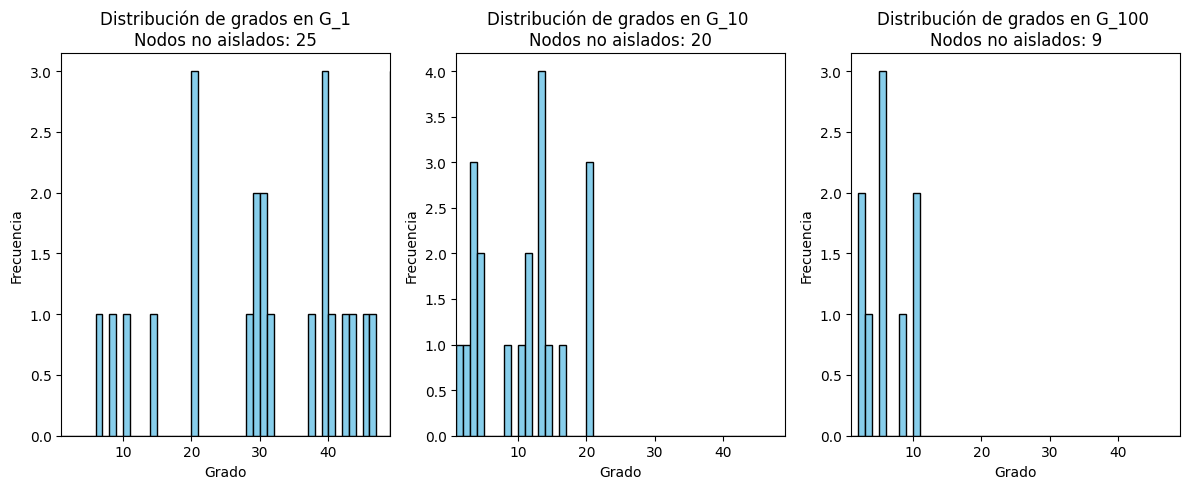

In [8]:
import matplotlib.pyplot as plt
from collections import Counter
import networkx as nx

# Función para obtener lista de grados
def get_degrees(G):
    return [degree for _, degree in G.degree()]

# Función para contar nodos no aislados
def count_non_isolated_nodes(G):
    return sum(1 for _, degree in G.degree() if degree > 0)

# Obtener listas de grados
degrees_G = get_degrees(G)
degrees_G2 = get_degrees(G)
degrees_G10 = get_degrees(G_10)
degrees_G100 = get_degrees(G_100)

# Calcular el rango común del eje X
all_degrees = degrees_G + degrees_G2 + degrees_G10 + degrees_G100
min_deg = min(all_degrees)
max_deg = max(all_degrees)
bins = range(min_deg, max_deg + 2)  # +2 para incluir el último valor como borde superior del último bin

# Dibujar histogramas individuales con el mismo rango de grados
plt.figure(figsize=(12, 5))

# Histograma 1
plt.subplot(1, 3, 1)
plt.hist(degrees_G, bins=bins, color='skyblue', edgecolor='black')
plt.title(f"Distribución de grados en G_1\nNodos no aislados: {count_non_isolated_nodes(G)}")
plt.xlabel("Grado")
plt.ylabel("Frecuencia")
plt.xlim(min_deg, max_deg)

# Histograma 3
plt.subplot(1, 3, 2)
plt.hist(degrees_G10, bins=bins, color='skyblue', edgecolor='black')
plt.title(f"Distribución de grados en G_10 \nNodos no aislados: {count_non_isolated_nodes(G_10)}")
plt.xlabel("Grado")
plt.ylabel("Frecuencia")
plt.xlim(min_deg, max_deg)

# Histograma 3
plt.subplot(1, 3, 3)
plt.hist(degrees_G100, bins=bins, color='skyblue', edgecolor='black')
plt.title(f"Distribución de grados en G_100 \nNodos no aislados: {count_non_isolated_nodes(G_100)}")
plt.xlabel("Grado")
plt.ylabel("Frecuencia")
plt.xlim(min_deg, max_deg)

plt.tight_layout()
plt.savefig("distribuciones_grados_cient.png", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Función para obtener la métrica deseada (ahora incluye weighted_degree)
def get_metric(G, metric_type="degree", weight=None):
    if metric_type == "degree_centrality":
        return nx.degree_centrality(G)
    elif metric_type == "betweenness_centrality":
        if weight:
            return nx.betweenness_centrality(G, weight=weight)
        return nx.betweenness_centrality(G)
    elif metric_type == "closeness_centrality":
        if weight:
            return nx.closeness_centrality(G, distance=weight)
        return nx.closeness_centrality(G)
    elif metric_type == "degree":
        if weight:
            return dict(G.degree(weight=weight))  # Grado ponderado
        return dict(G.degree())  # Grado simple (sin pesos)
    elif metric_type == "weighted_degree":  # Nueva opción para grado ponderado
        if nx.get_edge_attributes(G, weight if weight else 'weight'):
            return dict(G.degree(weight=weight if weight else 'weight'))
        else:
            print("Advertencia: No se encontraron pesos en las aristas. Usando grado simple.")
            return dict(G.degree())
    else:
        raise ValueError(f"Metric {metric_type} not recognized")

# Función para obtener lista de la métrica para cada nodo
def get_metric_values(G, metric_type="degree_centrality", weight=None):
    metrics = get_metric(G, metric_type, weight)
    return list(metrics.values())

# Listado de redes (como en tu ejemplo, puedes agregar más redes aquí)
networks = [G, G_2, G_10, G_100]
network_names = ["G", "G_2", "G_10", "G_100"]

# Definir la métrica que deseas estudiar
metric_type = "weighted_degree"  # Nueva opción para grado ponderado
weight_param = "weight"  # Nombre del atributo de peso en las aristas (ajusta según tu grafo)

# Crear el histograma para cada red
plt.figure(figsize=(15, 12))

# Recorrer las redes
for i, network in enumerate(networks):
    # Verificar si hay pesos en las aristas si la métrica es 'weighted_degree'
    if metric_type == "weighted_degree":
        edge_weights = nx.get_edge_attributes(network, weight_param)
        if not edge_weights:
            print(f"Red {network_names[i]} no tiene pesos en las aristas. Se usará grado simple.")
    
    metric_values = get_metric_values(network, metric_type, weight_param)
    
    # Crear el subplot para cada red
    plt.subplot(2, 2, i + 1)
    plt.hist(metric_values, bins=30, color='skyblue', edgecolor='black')
    plt.title(f"{network_names[i]} - {metric_type}")
    plt.xlabel(f"{metric_type} valor")
    plt.ylabel("Frecuencia")

# Ajustar la visualización
plt.tight_layout()
plt.show()

In [ ]:
import networkx as nx

# Función para obtener y ordenar nodos por weighted degree
def get_sorted_nodes_by_weighted_degree(G, weight_attr="weight"):
    # Usar grado ponderado si hay pesos, si no, grado simple
    if nx.get_edge_attributes(G, weight_attr):
        weighted_degrees = dict(G.degree(weight=weight_attr))
    else:
        print("Advertencia: No se encontraron pesos en la red. Se usará grado simple.")
        weighted_degrees = dict(G.degree())

    # Ordenar nodos por grado ponderado en orden descendente
    sorted_nodes = sorted(weighted_degrees.items(), key=lambda x: x[1], reverse=True)
    return sorted_nodes

# Obtener nodos ordenados por grado ponderado
sorted_G = get_sorted_nodes_by_weighted_degree(G)
sorted_G50 = get_sorted_nodes_by_weighted_degree(G_50)
sorted_G100 = get_sorted_nodes_by_weighted_degree(G_100)

# Mostrar resultados
print("Top nodos en G ordenados por grado ponderado:")
for node, value in sorted_G[:10]:  # Mostrar top 10 por ejemplo
    print(f"Nodo: {node}, Grado ponderado: {value}")

print("\nTop nodos en G_100 ordenados por grado ponderado:")
for node, value in sorted_G100[:10]:
    print(f"Nodo: {node}, Grado ponderado: {value}")


In [ ]:
# Función para obtener y ordenar una centralidad
def get_sorted_centrality(G, metric_type, weight=None):
    centrality = get_metric(G, metric_type, weight)
    return sorted(centrality.items(), key=lambda x: x[1], reverse=True)

# Elegir una métrica de centralidad
metric = "betweenness_centrality"  # Puedes cambiar a: "closeness_centrality", etc.

# Obtener top 10 nodos en cada red por esa centralidad
top_G = get_sorted_centrality(G, metric, weight="weight")[:10]
top_G100 = get_sorted_centrality(G_100, metric, weight="weight")[:10]

# Imprimir resultados como listas
print(f"\nTop 10 nodos en G por {metric}:\n")
for i, (node, value) in enumerate(top_G, start=1):
    print(f"{i}. Nodo {node} - Centralidad: {value:.6f}")

print(f"\nTop 10 nodos en G_100 por {metric}:\n")
for i, (node, value) in enumerate(top_G100, start=1):
    print(f"{i}. Nodo {node} - Centralidad: {value:.6f}")

# (Opcional) Gráfica comparativa
import matplotlib.pyplot as plt

nodes_G, values_G = zip(*top_G)
nodes_G100, values_G100 = zip(*top_G100)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))
axs[0].barh(nodes_G[::-1], values_G[::-1], color='steelblue')
axs[0].set_title(f'Top 10 nodos en G por {metric}')
axs[0].set_xlabel('Valor de centralidad')

axs[1].barh(nodes_G100[::-1], values_G100[::-1], color='darkorange')
axs[1].set_title(f'Top 10 nodos en G_100 por {metric}')
axs[1].set_xlabel('Valor de centralidad')

plt.tight_layout()
plt.show()


In [ ]:
def apply_weight_threshold(G, threshold):
    G_filtered = G.__class__()  # Preserva si es Graph, DiGraph, etc.
    for u, v, data in G.edges(data=True):
        if data['weight'] >= threshold:
            G_filtered.add_edge(u, v, weight=data['weight'])
    return G_filtered


# Aplicamos esta función con la función original, y los valores 2, 4 y 8, para aplicar distintos valores de Wm
G_2 = apply_weight_threshold(G, 2)
G_4 = apply_weight_threshold(G, 4)
G_10 = apply_weight_threshold(G, 10)
G_20 = apply_weight_threshold(G, 20)
G_50 = apply_weight_threshold(G, 50)
G_100 = apply_weight_threshold(G, 100)

In [ ]:
# Número total de comentarios en la red (ajusta según corresponda)
total_comentarios = 20387   # 32025

# Calcular el grado ponderado de entrada, normalizado
weighted_in_degrees = {k: v / total_comentarios for k, v in dict(G_100.in_degree(weight='weight')).items()}

# Layout
pos = nx.kamada_kawai_layout(G_100)

plt.figure(figsize=(14, 12))

# Dibujar nodos con tamaño proporcional al grado de entrada normalizado
nx.draw_networkx_nodes(G_100, pos,
                       node_size=[v * 15000 for v in weighted_in_degrees.values()],  # escala visual ajustable
                       node_color='lightcoral',
                       edgecolors='black',
                       alpha=0.9)

# Dibujar aristas con pesos normalizados
nx.draw_networkx_edges(G_100, pos,
                       edge_color='gray',
                       arrows=True,
                       arrowsize=15,
                       width=[d['weight'] / total_comentarios * 100 for _, _, d in G_100.edges(data=True)],
                       connectionstyle='arc3,rad=0.1')

# Etiquetas solo de los nodos más relevantes
top_nodes = sorted(weighted_in_degrees.items(), key=lambda x: x[1], reverse=True)
labels = {node: node for node, _ in top_nodes}
nx.draw_networkx_labels(G_100, pos, labels, font_size=10)

plt.title("Grafo dirigido G_100 con pesos normalizados", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

